# Argo `MTIME` global distribution and `DOXY` distribution

- Create a map of all floats with both `MTIME` and `DOXY` variables
- Create a map of all Argo recent `DOXY` profiles (say, > 2021) showing the maximum gradient
- Attempt to correct sensor response time in some example floats

In [46]:
import numpy as np

import argopandas as argo
import bgcArgoDMQC as bgc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')
import cmocean.cm as cmo

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Get the different data sets we require. This code

- Grabs any profiles that have both `MTIME` and `DOXY` parameters (subsetting using the parameters field of the BGC Argo Index)
- Gets the `PRES`, `MTIME`, `DOXY` data from the files
- Checks which profiles contain valid time and oxygen data
- Removes any file that do not have co-incident not-NaN values for time and oxygen
- Then, separately, recent oxygen profiles and load the data

In [26]:
index_time = argo.bio_prof.subset_parameter('MTIME').subset_parameter('DOXY')
data_time = index_time.levels[['PRES', 'MTIME', 'DOXY', 'DOXY_QC']]
data_time = data_time[(data_time.MTIME.notna()) & (data_time.DOXY.notna())]
index_time = index_time[index_time.file.isin(data_time.index.unique('file'))]
index_doxy = argo.bio_prof.subset_date('08-2022').subset_parameter('DOXY')
data_doxy = index_doxy.levels[['PRES', 'DOXY', 'DOXY_QC']]
data_doxy = data_doxy[data_doxy.DOXY.notna()]
index_doxy = index_doxy[index_doxy.file.isin(data_doxy.index.unique('file'))]


Reading 169 files
[==============================> ]  95% BR4902409_158.nc              c:\ProgramData\Anaconda3\envs\py39\lib\site-packages\argopandas\netcdf.py:147: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return var[:]
c:\ProgramData\Anaconda3\envs\py39\lib\site-packages\argopandas\netcdf.py:147: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return var[:]
Reading 4981 files                                                    


Check the composition of the data - there are 167 profiles from 9 different floats, 7 of which are from the MEDS DAC and 2 from Coriolis.

In [27]:
index_time['dac'] = [f.split('/')[0] for f in index_time.file]
index_time['wmo'] = [int(f.split('/')[1]) for f in index_time.file]
print(index_time)
print(index_time.wmo.unique())


                                              file                      date  \
155591  coriolis/6902670/profiles/BD6902670_001.nc 2017-07-20 16:16:35+00:00   
155592  coriolis/6902670/profiles/BD6902670_002.nc 2017-07-21 15:43:00+00:00   
155593  coriolis/6902670/profiles/BD6902670_003.nc 2017-07-22 15:40:55+00:00   
155594  coriolis/6902670/profiles/BD6902670_004.nc 2017-07-23 15:37:02+00:00   
155595  coriolis/6902670/profiles/BD6902670_005.nc 2017-07-24 15:38:58+00:00   
...                                            ...                       ...   
268285      meds/4902550/profiles/BR4902550_036.nc 2022-01-29 08:55:00+00:00   
268363      meds/4902551/profiles/BR4902551_053.nc 2022-01-27 09:05:00+00:00   
268427      meds/4902552/profiles/BR4902552_036.nc 2022-01-27 09:09:00+00:00   
268491      meds/4902553/profiles/BR4902553_036.nc 2022-01-28 08:54:00+00:00   
268616      meds/4902555/profiles/BR4902555_036.nc 2022-01-31 10:02:00+00:00   

        latitude  longitude ocean  prof

Plot the profiles - data is split between the North Atlantic and North Pacific.

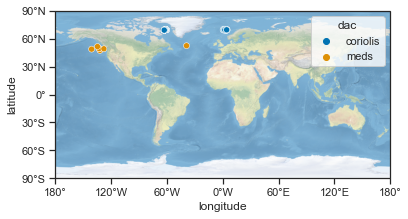

In [49]:
def format_global_map(ax):
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

fig = plt.figure()
axis = fig.add_subplot(projection=ccrs.PlateCarree())
axis.set_global()
# axis.coastlines()
axis.stock_img()
sns.scatterplot(x='longitude', y='latitude', hue='dac', data=index_time, ax=axis, transform=ccrs.PlateCarree())
format_global_map(axis)
fig.savefig('MTIME_DOXY_floats.png', bbox_inches='tight', dpi=300)

Calculate the maximum gradient for each oxygen profile.

In [29]:
def max_gradient(pres, doxy):
    grad = doxy.diff()/pres.diff()
    max_grad = -np.inf
    for i in grad.index.unique('N_PROF'):
        max_grad = max(max_grad, grad.loc[i][grad.loc[i].abs() < 99999].abs().max())
    return max_grad

index_doxy['max_doxy_grad'] = [max_gradient(data_doxy.loc[i].PRES, data_doxy.loc[i].DOXY) for i in index_doxy.file]
index_doxy['max_doxy_grad'][index_doxy['max_doxy_grad'] < 0] = np.nan



C:\Users\GordonC\AppData\Local\Temp\1/ipykernel_5940/1749422323.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_doxy['max_doxy_grad'][index_doxy['max_doxy_grad'] < 0] = np.nan


Plot the max gradient on a map to get an idea of spatial distribution, which regions might benefit the most from time response correction. Also plot the distribution of gradients.

(0.0, 50.0)

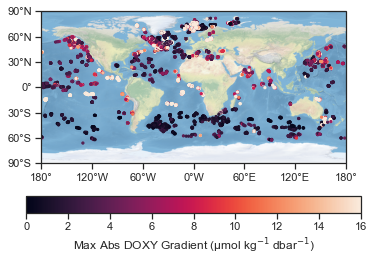

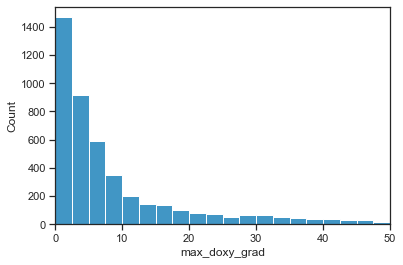

In [50]:
fig = plt.figure()
axis = fig.add_subplot(projection=ccrs.PlateCarree())
axis.set_global()
# axis.coastlines()
axis.stock_img()
g = axis.scatter(
    x=index_doxy.longitude, y=index_doxy.latitude, 
    c=index_doxy.max_doxy_grad, cmap=cmo.dense,
    s=5, vmin=0, vmax=16, 
    transform=ccrs.PlateCarree()
)
cb = plt.colorbar(g, orientation='horizontal')
cb.set_label('Max Abs DOXY Gradient ($\mathregular{\mu}$mol kg$^{-1}$ dbar$^{-1}$)')

format_global_map(axis)

fig.savefig('DOXY_GRADIENT_map.png', bbox_inches='tight', dpi=300)

fig, ax = plt.subplots()
sns.histplot(index_doxy.max_doxy_grad, kde=False, ax=ax, bins=np.arange(0, 52.5, 2.5))
ax.set_xlim((0, 50))
